# Anime Recommendation Model

#### Original Author: Thien-An Bui

### Load in Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import pickle
from scipy.spatial.distance import cosine

random.seed(1242)

### Load in the Data

In [4]:
# Load the data from the CSV file
animes = pd.read_csv('animes.csv')
users = pd.read_csv('profiles_modified.csv')

# Handle the 'aired' column in the animes dataset
def parse_aired_date(date_range):
    if pd.isna(date_range):
        return None
    # Split the range and take the start date
    start_date = date_range.split(' to ')[0]
    try:
        return pd.to_datetime(start_date, format='%b %d, %Y', errors='coerce')
    except ValueError:
        return None

animes['aired_start'] = animes['aired'].apply(parse_aired_date)

# Handle the 'birthday' column in the users dataset
def parse_birthday(birthday):
    if pd.isna(birthday):
        return None
    try:
        return pd.to_datetime(birthday, format='%d-%b-%y', errors='coerce')
    except ValueError:
        return None

users['birthday_parsed'] = users['birthday'].apply(parse_birthday)

# Print dataset shapes for confirmation
print(animes.shape)
print(users.shape)

(19311, 13)
(81727, 7)


In [5]:
animes

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link,aired_start
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...,2015-10-04
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...,2014-10-10
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss,2017-07-07
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...,2009-04-05
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...,2017-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19306,32979,Flip Flappers,Cocona is an average middle schooler living wi...,"['Sci-Fi', 'Adventure', 'Comedy', 'Magic']","Oct 6, 2016 to Dec 29, 2016",13.0,134252,843,1070.0,7.73,https://cdn.myanimelist.net/images/anime/4/822...,https://myanimelist.net/anime/32979/Flip_Flappers,2016-10-06
19307,123,Fushigi Yuugi,"While visiting the National Library, junior-hi...","['Adventure', 'Fantasy', 'Magic', 'Martial Art...","Apr 6, 1995 to Mar 28, 1996",52.0,84407,1292,1071.0,7.73,https://cdn.myanimelist.net/images/anime/2/201...,https://myanimelist.net/anime/123/Fushigi_Yuugi,1995-04-06
19308,1281,Gakkou no Kaidan,"Years ago, all of the ghosts in a haunted scho...","['Mystery', 'Horror', 'Supernatural']","Oct 22, 2000 to Mar 25, 2001",19.0,83093,1314,1073.0,7.73,https://cdn.myanimelist.net/images/anime/9/183...,https://myanimelist.net/anime/1281/Gakkou_no_K...,2000-10-22
19309,450,InuYasha Movie 2: Kagami no Naka no Mugenjo,Inuyasha and company have finally destroyed Na...,"['Action', 'Adventure', 'Comedy', 'Historical'...","Dec 21, 2002",1.0,71989,1469,1077.0,7.73,https://cdn.myanimelist.net/images/anime/1162/...,https://myanimelist.net/anime/450/InuYasha_Mov...,2002-12-21


In [6]:
users

,user_id,profile,gender,birthday,favorite_anime,link,birthday_parsed
0,1,DesolatePsyche,Male,2-Oct-94,"['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche,1994-10-02
1,2,baekbeans,Female,10-Nov-00,"['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans,2000-11-10
2,3,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn,NaT
3,4,edgewalker00,Male,5-Sep,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00,NaT
4,5,aManOfCulture99,Male,30-Oct-99,"['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99,1999-10-30
...,...,...,...,...,...,...,...
81722,81723,lovelessxd,Female,6-Aug-92,"['853', '5114']",https://myanimelist.net/profile/lovelessxd,1992-08-06
81723,81724,Shattered_Angel,Female,6-Sep-94,"['150', '27', '1520', '121', '31452', '32995',...",https://myanimelist.net/profile/Shattered_Angel,1994-09-06
81724,81725,FluffyWalrus,Male,NaN,"['121', '43', '237', '202', '205']",https://myanimelist.net/profile/FluffyWalrus,NaT
81725,81726,camco,Female,23-Sep,"['199', '4224', '7054', '13601', '14713']",https://myanimelist.net/profile/camco,NaT


### EDA

#### Animes Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19311 entries, 0 to 19310
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   uid          19311 non-null  int64         
 1   title        19311 non-null  object        
 2   synopsis     18336 non-null  object        
 3   genre        19311 non-null  object        
 4   aired        19311 non-null  object        
 5   episodes     18605 non-null  float64       
 6   members      19311 non-null  int64         
 7   popularity   19311 non-null  int64         
 8   ranked       16099 non-null  float64       
 9   score        18732 non-null  float64       
 10  img_url      19131 non-null  object        
 11  link         19311 non-null  object        
 12  aired_start  17139 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 1.9+ MB
None
                uid      episodes       members    popularity        r

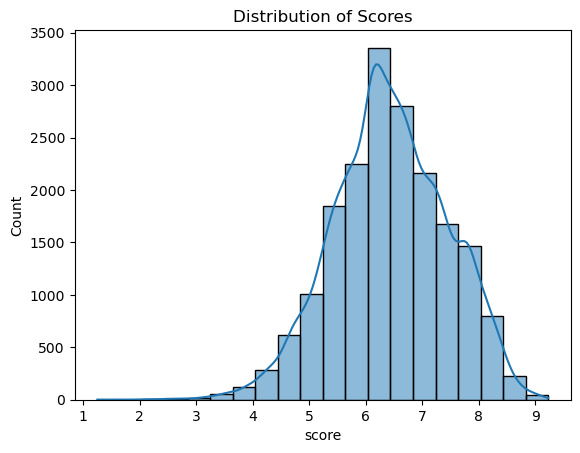

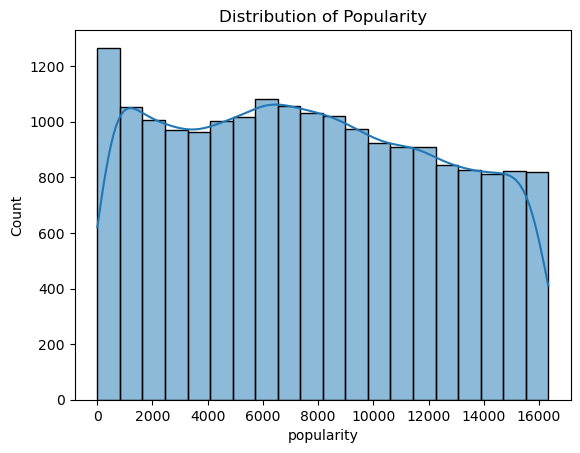

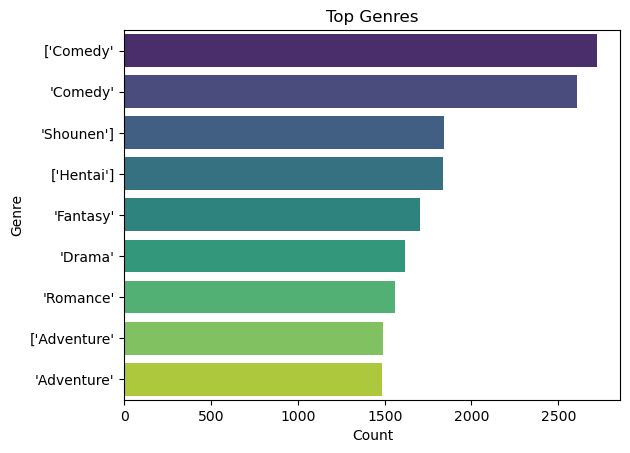

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information about the dataset
print(animes.info())

# Summary statistics of numerical columns
print(animes.describe())

# Distribution of Scores
sns.histplot(animes['score'], bins=20, kde=True)
plt.title('Distribution of Scores')
plt.show()

# Distribution of Popularity
sns.histplot(animes['popularity'], bins=20, kde=True)
plt.title('Distribution of Popularity')
plt.show()

# Genres distribution
genres_count = animes['genre'].str.split(', ', expand=True).stack().value_counts().iloc[1:10]

# Create a DataFrame for Seaborn barplot compatibility
genres_df = pd.DataFrame({'Genre': genres_count.index, 'Count': genres_count.values})

sns.barplot(data=genres_df, x='Count', y='Genre', palette='viridis', hue='Genre', dodge=False, legend=False)
plt.title('Top Genres')
plt.xlabel('Count')
plt.show()


#### Users Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81727 entries, 0 to 81726
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          81727 non-null  int64         
 1   profile          81727 non-null  object        
 2   gender           53856 non-null  object        
 3   birthday         46807 non-null  object        
 4   favorite_anime   81727 non-null  object        
 5   link             81727 non-null  object        
 6   birthday_parsed  36339 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 4.4+ MB
None
            user_id                birthday_parsed
count  81727.000000                          36339
mean   40864.000000  1995-08-07 12:23:23.979195904
min        1.000000            1969-01-01 00:00:00
25%    20432.500000            1992-02-04 00:00:00
50%    40864.000000            1995-08-03 00:00:00
75%    61295.500000            1998

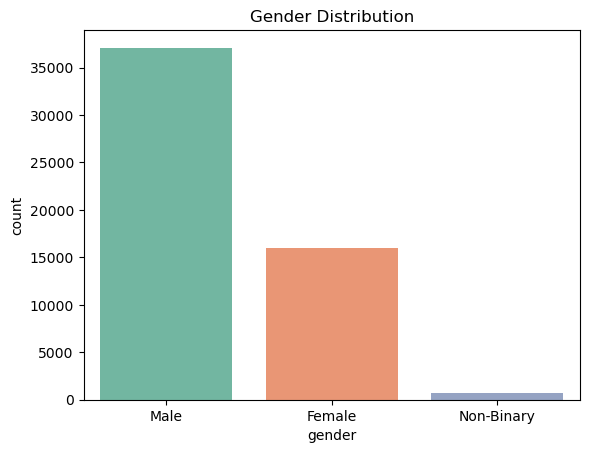

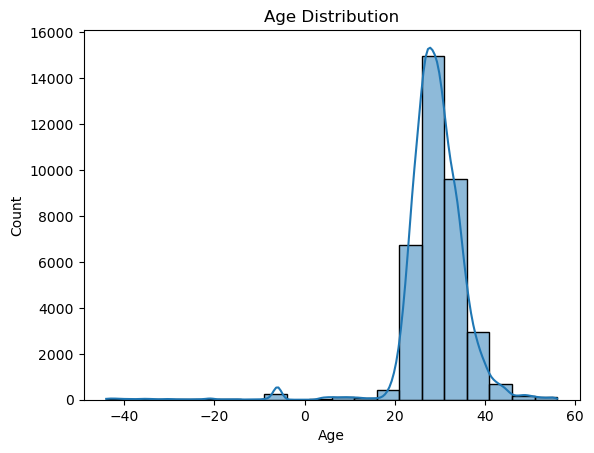

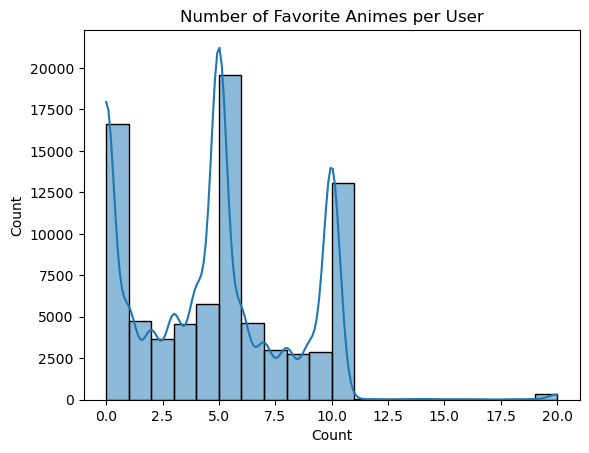

In [11]:
# Display basic information about the dataset
print(users.info())

# Summary statistics of numerical columns (if any)
print(users.describe())

# Gender distribution
sns.countplot(x='gender', data=users, hue='gender', palette='Set2', legend=False)
plt.title('Gender Distribution')
plt.show()

# Convert 'birthday' to datetime format with a specified format
users['birthday'] = pd.to_datetime(users['birthday'], format='%d-%b-%y', errors='coerce')

# Calculate age
users['age'] = (pd.Timestamp.today() - users['birthday']).dt.days // 365

# Plot the age distribution
sns.histplot(x='age', data=users, bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

# Number of favorite animes per user
users['favorite_count'] = users['favorite_anime'].apply(lambda x: len(eval(x)))
sns.histplot(x='favorite_count', data=users, bins=20, kde=True)
plt.title('Number of Favorite Animes per User')
plt.xlabel('Count')
plt.show()

### Feature Engineering and Data Prep

In [13]:
users.isnull().sum()


user_id                0
profile                0
gender             27871
birthday           45388
favorite_anime         0
link                   0
birthday_parsed    45388
age                45388
favorite_count         0
dtype: int64

#### We have some user profiles with no favorite animes listed. 

In [15]:
users[users['user_id'] == 10]

,user_id,profile,gender,birthday,favorite_anime,link,birthday_parsed,age,favorite_count
9,10,shadowsplat,NaN,NaT,[],https://myanimelist.net/profile/shadowsplat,NaT,NaN,0


We will omit these from our analysis since we will be comparing user profiles based on their favorited animes.

In [17]:
users = users[users['favorite_anime'] != '[]']

### Prepare a DataFrame for Modeling

In [26]:
# Extract unique anime IDs
unique_anime_ids = set(anime_id for anime_list in users['favorite_anime'] for anime_id in eval(anime_list))

# Create a dictionary to hold the dummy variables
dummy_data = {}

for anime_id in unique_anime_ids:
    dummy_data[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)

# Combine all dummy columns into a single DataFrame
dummy_df = pd.DataFrame(dummy_data)

# Add the user_id column and join with dummy DataFrame
user_anime_dataset = pd.concat([users[['user_id']].reset_index(drop=True), dummy_df], axis=1)

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_anime_dataset[f'anime_{anime_id}'] = users['favorite_anime'].apply(lambda x: 1 if anime_id in eval(x) else 0)
C:\Users\tab\AppData\Local\Temp\ipykernel_2392\4053157834.py:8: PerformanceWarning: 

In [27]:
# Check for duplicate user IDs
user_anime_dataset[user_anime_dataset.duplicated(subset='user_id', keep=False)]

# Example: Remove duplicates (keep the first occurrence)
user_anime_dataset = user_anime_dataset.drop_duplicates(subset='user_id', keep='first')

# Remove NAs
user_anime_dataset = user_anime_dataset.dropna()


In [30]:
# Extract the anime IDs (removing 'anime_' prefix)
anime_ids = [int(col.split('_')[1]) for col in user_anime_dataset.columns if col.startswith('anime_')]

# Create a mapping from uid to title
anime_title_mapping = animes.set_index('uid')['title'].to_dict()

# Rename the columns of user_anime_dataset based on the title mapping
new_column_names = [anime_title_mapping.get(anime_id, f'anime_{anime_id}') for anime_id in anime_ids]

# Add the 'user_id' column back to the new column names
new_column_names = ['user_id'] + new_column_names

# Apply the new column names to the user_anime_dataset
user_anime_dataset.columns = new_column_names

# Display the resulting dataset
print(user_anime_dataset.head())


   user_id  Yama Hime no Mi  Code Geass: Hangyaku no Lelouch R2  \
0      1.0              0.0                                 1.0   
1      2.0              0.0                                 0.0   
2      3.0              0.0                                 1.0   
3      4.0              0.0                                 1.0   
4      5.0              0.0                                 0.0   

   Onegai☆Teacher  Mazinger Z  Tegamibachi Reverse  Nozoki Ana  \
0             0.0         0.0                  0.0         0.0   
1             0.0         0.0                  0.0         0.0   
2             0.0         0.0                  0.0         0.0   
3             0.0         0.0                  0.0         0.0   
4             0.0         0.0                  0.0         0.0   

   Soredemo Tsuma wo Aishiteru  Katanagatari  Mushishi: Hihamukage  ...  \
0                          0.0           1.0                   0.0  ...   
1                          0.0           0.0      

In [32]:
anime_title_mapping

{28891: 'Haikyuu!! Second Season',
 23273: 'Shigatsu wa Kimi no Uso',
 34599: 'Made in Abyss',
 5114: 'Fullmetal Alchemist: Brotherhood',
 31758: 'Kizumonogatari III: Reiketsu-hen',
 37510: 'Mob Psycho 100 II',
 199: 'Sen to Chihiro no Kamikakushi',
 38000: 'Kimetsu no Yaiba',
 35247: 'Owarimonogatari 2nd Season',
 2904: 'Code Geass: Hangyaku no Lelouch R2',
 32935: 'Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou',
 34096: 'Gintama.',
 15335: 'Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare',
 918: 'Gintama',
 4181: 'Clannad: After Story',
 15417: "Gintama': Enchousen",
 30276: 'One Punch Man',
 16664: 'Kaguya-hime no Monogatari',
 4672: 'Koukaku Kidoutai 2.0',
 8038: 'Nodame Cantabile: Finale - Mine to Kiyora no Saikai',
 7588: 'Saraiya Goyou',
 1253: 'Saint Seiya: Meiou Hades Meikai-hen',
 20767: 'Noragami OVA',
 1425: 'Lupin III: Part II',
 35363: 'Kobayashi-san Chi no Maid Dragon: Valentine, Soshite Onsen! - Amari Kitai Shinaide Kudasai',
 22673: 'Kuroko no Basket

In [33]:
user_anime_dataset

,user_id,Yama Hime no Mi,Code Geass: Hangyaku no Lelouch R2,Onegai☆Teacher,Mazinger Z,Tegamibachi Reverse,Nozoki Ana,Soredemo Tsuma wo Aishiteru,Katanagatari,Mushishi: Hihamukage,...,Kyoukai no Kanata: Shinonome,Kuroko no Basket 3rd Season NG-shuu,Juuni Kokuki,Sei Juushi Bismarck,Pupipo!,Lupin III (2015),Grimm Masterpiece Theater,Kuragehime,Wakaba*Girl,Pokemon Sun & Moon
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65119,81721.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65120,81723.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65121,81724.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65122,81725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Testing to ensure these are all displaying "1"
selected_anime_uids = ['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']

# Filter the user_anime_dataset for user_id = 1 and selected anime columns
anime_title_mapping = animes.set_index('uid')['title'].to_dict()
selected_titles = [anime_title_mapping.get(int(uid), f'anime_{uid}') for uid in selected_anime_uids]

# Step 2: Filter for user_id = 1 and selected columns
selected_row = user_anime_dataset[user_anime_dataset['user_id'] == 1][['user_id'] + selected_titles]

# Display the result
print(selected_row)

   user_id  Violet Evergarden  Akatsuki no Yona  Pandora Hearts  \
0      1.0                1.0               1.0             1.0   

   No Game No Life: Zero  D.Gray-man  Bleach  White Album 2  \
0                    1.0         1.0     1.0            1.0   

   Code Geass: Hangyaku no Lelouch R2  Tokyo Ghoul √A  ...  Acchi Kocchi (TV)  \
0                                 1.0             1.0  ...                1.0   

   Elfen Lied  Koe no Katachi  Kami nomi zo Shiru Sekai  Katanagatari  \
0         1.0             1.0                       1.0           1.0   

   Casshern Sins  Nodame Cantabile  Mushishi  Detective Conan (TV)  Blend S  
0            1.0               1.0       1.0                   1.0      1.0  

[1 rows x 21 columns]


Our dataset was created as intended.

In [36]:
# We will save the generated DataFrame to an external CSV file
user_anime_dataset['user_id'] = user_anime_dataset['user_id'].astype(int)
user_anime_dataset.to_csv('user_anime_dataset.csv', index = False)

## For each run after this, load in the dataset

In [38]:
user_anime_dataset = pd.read_csv('user_anime_dataset.csv')
user_anime_dataset['user_id'] = user_anime_dataset['user_id'].astype(int)


### Item-to-Item Collaborative Filtering

In [40]:
# Create a function to calculate cosine similarity between two items
def calculate_cosine_similarity(item1, item2):
    return 1 - cosine(item1, item2)

In [41]:
# Select users who have favorited 'One Punch Man' and 'Haikyuu!!'
selected_users = user_anime_dataset[(user_anime_dataset['One Punch Man'] == 1) & 
                                    (user_anime_dataset['Haikyuu!!'] == 1)]

# Extract the columns related to animes (excluding 'user_id')
anime_columns = [col for col in selected_users.columns if col != 'user_id']

# Calculate cosine similarity for each anime with 'One Punch Man' and 'Haikyuu!!'
similarities = pd.DataFrame(index=anime_columns, columns=['Similarity'])

for col in anime_columns:
    vector_1 = selected_users['One Punch Man']
    vector_2 = selected_users[col]
    
    # Calculate magnitudes
    magnitude_1 = (vector_1 ** 2).sum() ** 0.5
    magnitude_2 = (vector_2 ** 2).sum() ** 0.5
    
    if magnitude_1 == 0 or magnitude_2 == 0:
        # Assign NaN or 0 similarity if either vector has zero magnitude
        similarities.loc[col] = float('nan')  # or 0 if you prefer
    else:
        # Calculate cosine similarity
        similarity = calculate_cosine_similarity(vector_1, vector_2)
        similarities.loc[col] = similarity

# Sort animes by similarity and recommend the top 6
recommendations = similarities.sort_values(by='Similarity', ascending=False).head(6)

# Display the recommended animes
print(recommendations)

                                 Similarity
Haikyuu!!                               1.0
One Punch Man                           1.0
Fullmetal Alchemist: Brotherhood   0.559017
One Piece                          0.549621
Hunter x Hunter (2011)             0.520416
Steins;Gate                        0.444878


All of these recommended animes fall into similar genres as our selected animes (One Punch Man and Haikyuu!!).

### User-to-User Collaborative Filtering

In [44]:
# Select user 50
target_user_id = 50
target_user = user_anime_dataset[user_anime_dataset['user_id'] == target_user_id].set_index('user_id')
target_user_animes = target_user.columns[target_user.values.flatten() == 1]

# Calculate cosine similarity with all users
similarities = pd.DataFrame(index = user_anime_dataset['user_id'].unique(), columns = ['Similarity'])

for index, row in user_anime_dataset.iterrows():
    similarity = calculate_cosine_similarity(target_user.values.flatten(), row.values[1:])
    similarities.loc[row['user_id']] = similarity


# Filter out the target user from the similarity values
similarities = similarities[similarities.index != target_user_id]

# Find the most similar user with similarity less than 1 (highest value below 1)
most_similar_user_id = similarities[similarities['Similarity'] < 1].sort_values(by = 'Similarity', ascending = False).index[0]

# List recommended animes for user based on the most similar user
recommended_animes = user_anime_dataset.columns[1:][user_anime_dataset[user_anime_dataset['user_id'] == most_similar_user_id].iloc[:, 1:].values.flatten() == 1]

# Exclude any animes that the targeted user profile has already listed/favorited
recommended_animes = [anime for anime in recommended_animes if anime not in target_user_animes]

# Convert the variable to a string.
recommended_animes = ', '.join(map(str, recommended_animes))

# Display the recommended animes
print(f"The most similar user to user {target_user_id} is user {most_similar_user_id}.")
print(f"We would recommend the following based on their most similar user profile: {recommended_animes}. \n")

The most similar user to user 50 is user 20897.
We would recommend the following based on their most similar user profile: Kenpuu Denki Berserk. 



In [45]:
target_user_animes

Index(['Akira', 'Afro Samurai', 'Gunnm', 'Samurai Champloo', 'Cowboy Bebop'], dtype='object')

The recommendation system returns the profile with the most similarities to our target user profile (excluding identical listings to the target user's favorited animes) and uses this to recommend the target user with a new show they may enjoy based on their provided preferences.

### Use a combination of user-item approach to build a recommendation score for each anime for each user 

In [48]:
from scipy.spatial.distance import cosine

# Select target user
target_user_id = 50
target_user = user_anime_dataset[user_anime_dataset['user_id'] == target_user_id].set_index('user_id')
target_user_animes = target_user.columns[target_user.values.flatten() == 1]

# Calculate cosine similarity with all users
similarities = pd.DataFrame(index = user_anime_dataset['user_id'].unique(), columns = ['Similarity'])

for index, row in user_anime_dataset.iterrows():
    similarity = calculate_cosine_similarity(target_user.values.flatten(), row.values[1:])
    similarities.loc[row['user_id']] = similarity

# Find the top 5 most similar users
top_5_most_similar = similarities.sort_values(by = 'Similarity', ascending = False).head(5)

# Initialize an empty DataFrame for recommendation scores
recommendation_scores = pd.DataFrame(index = user_anime_dataset['user_id'].unique(), columns = user_anime_dataset.columns[1:])

# Fill in recommendation scores for each user and anime
for index, row in user_anime_dataset.iterrows():
    if row['user_id'] == target_user_id:
        continue  # Skip the target user
    
    # Calculate recommendation score using a combination of user and item approach
    recommendation_scores.loc[row['user_id']] = row.values[1:] * similarities.loc[row['user_id'], 'Similarity']

# Sum recommendation scores across similar users for each anime
anime_recommendation_scores = recommendation_scores.sum(axis = 0)

# Exclude animes that the target user has already seen
anime_recommendation_scores = anime_recommendation_scores[anime_recommendation_scores.index.isin(target_user_animes) == False]

# Sort and get the top 10 recommended animes
top_10_recommendations = anime_recommendation_scores.sort_values(ascending = False).head(10)

# Convert the variable to a string
top_10_recommendations_str = ', '.join(map(str, top_10_recommendations.index))

# Display the top 5 most similar users and top 10 recommended animes
print(f"The top 5 most similar users to user {target_user_id} are {top_5_most_similar}.")
print(f"We would recommend the following based on a combination of user-item approach: {top_10_recommendations_str}. \n")


The top 5 most similar users to user 50 are       Similarity
50           1.0
39475        1.0
33833        1.0
20897    0.67082
2243    0.632456.
We would recommend the following based on a combination of user-item approach: Fullmetal Alchemist: Brotherhood, Neon Genesis Evangelion, Steins;Gate, Tengen Toppa Gurren Lagann, Hunter x Hunter (2011), Death Note, FLCL, Mushishi, Code Geass: Hangyaku no Lelouch, Baccano!. 



### Analysis

Our target profile's favorited animes were:
- Akira
- Afro Samurai
- Gunnm
- Samurai Champloo
- Cowboy Bebop

Our model returned the following set of recommendations.

- Fullmetal Alchemist: Brotherhood
- Neon Genesis Evangelion
- Steins;Gate
- Tengen Toppa Gurren Lagann
- Hunter x Hunter (2011)
- Death Note
- FLCL
- Mushishi
- Code Geass: Hangyaku no Lelouch
- Baccano!

Comments:
- Overall, our model does well in providing similar recommendations to the user based on what they have favorited. 
- We see that the model's recommendations trend towards action-adventure animes, noting that the first half of the list falls under this category.
- There is mix of supernatural and thriller animes (Death Note, Baccano, etc.) that are likely off-branches from Akira's thematics.